# 7장 타이타닉 생존자 예측하기

## 학습 목표
1. 데이터 탐색(EDA)을 통해 **데이터의 특성과 분포**를 이해할 수 있다
2. **상관관계 분석**을 통해 생존에 영향을 미치는 요인을 파악할 수 있다
3. **나이, 성별, 등급별 생존률**을 시각화하고 분석할 수 있다
4. 이름에서 **호칭(Title)을 추출**하여 새로운 특성을 생성할 수 있다
5. **DecisionTreeClassifier**를 사용하여 생존자 예측 모델을 구축할 수 있다

## 주요 내용
- 데이터 로드 및 기본 정보 확인
- 생존률 시각화 (Pie Chart, Count Plot)
- 상관관계 히트맵 분석
- 나이대별/성별/등급별 생존률 분석
- 이름에서 호칭 추출 및 범주화
- Decision Tree 모델 학습 및 평가

## 7-1. 데이터 읽고 전체적인 상황 확인하기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Google Colab 사용 시에만 필요 (로컬 환경에서는 주석 처리)
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# 로컬 환경용 경로
csvPath = 'data/titanic/train.csv'
raw_data = pd.read_csv(csvPath)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
raw_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


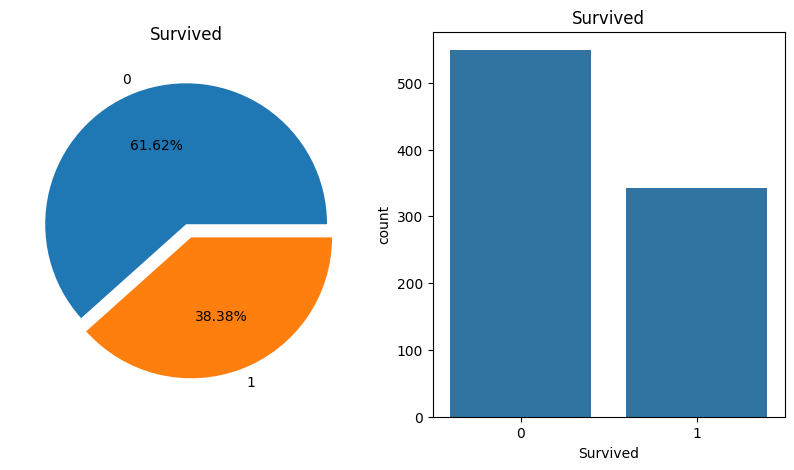

In [6]:
# 생존 여부 분포 시각화
f,ax=plt.subplots(1,2,figsize=(10,5))

raw_data['Survived'].value_counts().plot.pie(explode=[0,0.1],
                                             autopct='%1.2f%%',ax=ax[0])
ax[0].set_title('Survived')
ax[0].set_ylabel('')

# seaborn 최신 버전에서는 x 파라미터를 명시적으로 지정해야 함
sns.countplot(x='Survived', data=raw_data, ax=ax[1])
ax[1].set_title('Survived')
plt.show()

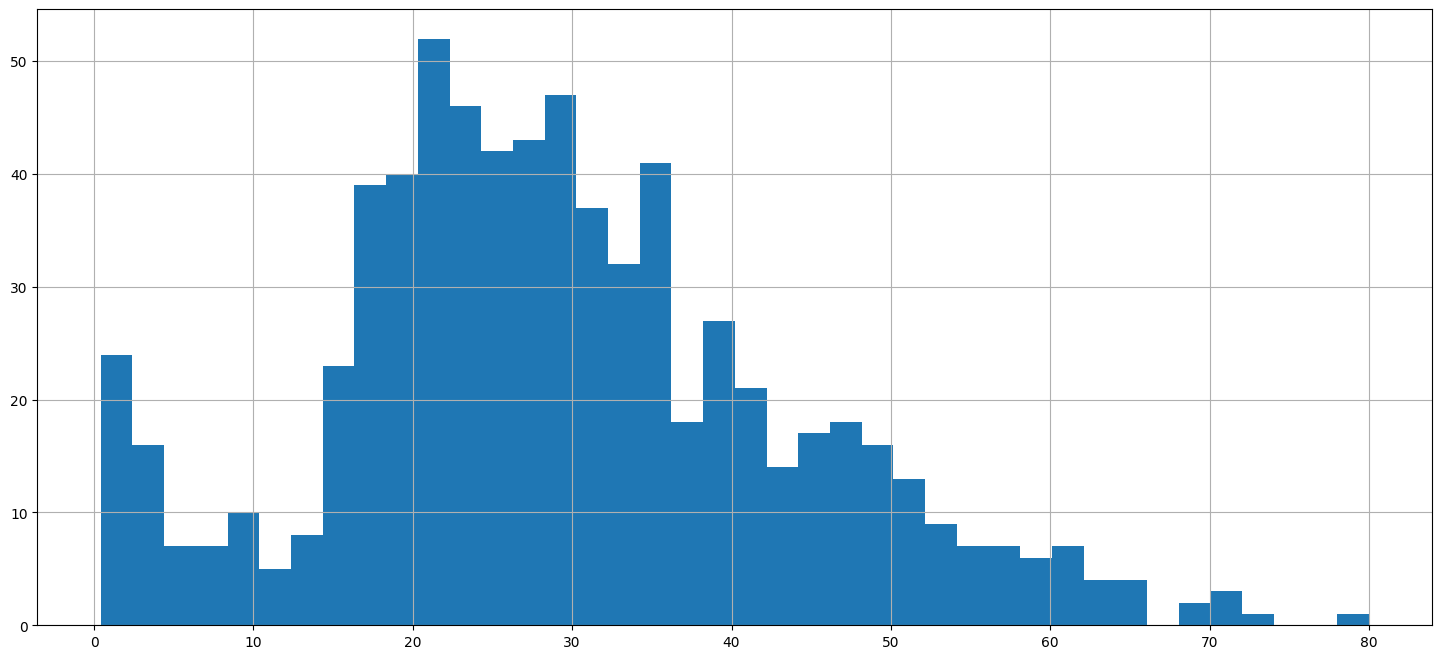

In [7]:
raw_data['Age'].hist(bins=40,figsize=(18,8),grid=True);

In [8]:
# 등급(Pclass)별 평균값 확인
# pandas 2.0+ 에서는 numeric_only=True를 명시적으로 지정해야 함
raw_data.groupby('Pclass').mean(numeric_only=True)

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


In [9]:
# 상관관계 분석
# pandas 2.0+ 에서는 numeric_only=True를 명시적으로 지정해야 함
raw_data.corr(numeric_only=True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


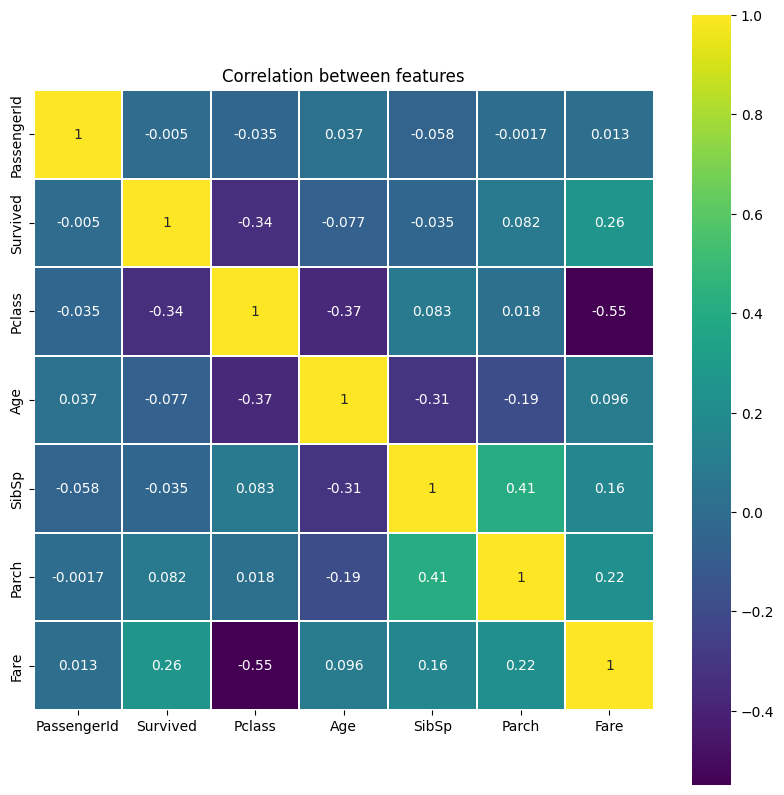

In [10]:
# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(raw_data.corr(numeric_only=True), linewidths=0.01, square=True,
            annot=True, cmap=plt.cm.viridis, linecolor="white")
plt.title('Correlation between features')
plt.show()

## 7-3. 나이별 구별 및 성별 생존률 확인하기

In [11]:
raw_data['Age_cat'] = pd.cut(raw_data['Age'], 
                             bins=[0, 3, 7, 15, 30, 60, 81], 
                             include_lowest=True, 
                             labels=['baby', 'children', 'teenage', 
                                     'young', 'adult', 'old'])
raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,young
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,young
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult


In [12]:
# 나이대별 평균값 확인
raw_data.groupby('Age_cat').mean(numeric_only=True)

C:\Users\park0\AppData\Local\Temp\ipykernel_42524\1217178947.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  raw_data.groupby('Age_cat').mean(numeric_only=True)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Age_cat,,,,,,,
baby,396.700000,0.666667,2.533333,1.672333,1.733333,1.366667,33.364307
children,466.700000,0.700000,2.650000,4.950000,1.750000,1.350000,27.905830
teenage,442.060606,0.454545,2.696970,11.500000,1.727273,1.121212,35.217430
young,435.058282,0.358896,2.426380,23.262270,0.355828,0.263804,28.015413
adult,470.388693,0.420495,1.954064,41.132509,0.363958,0.392226,42.429225
old,432.545455,0.227273,1.590909,66.022727,0.136364,0.272727,41.371214


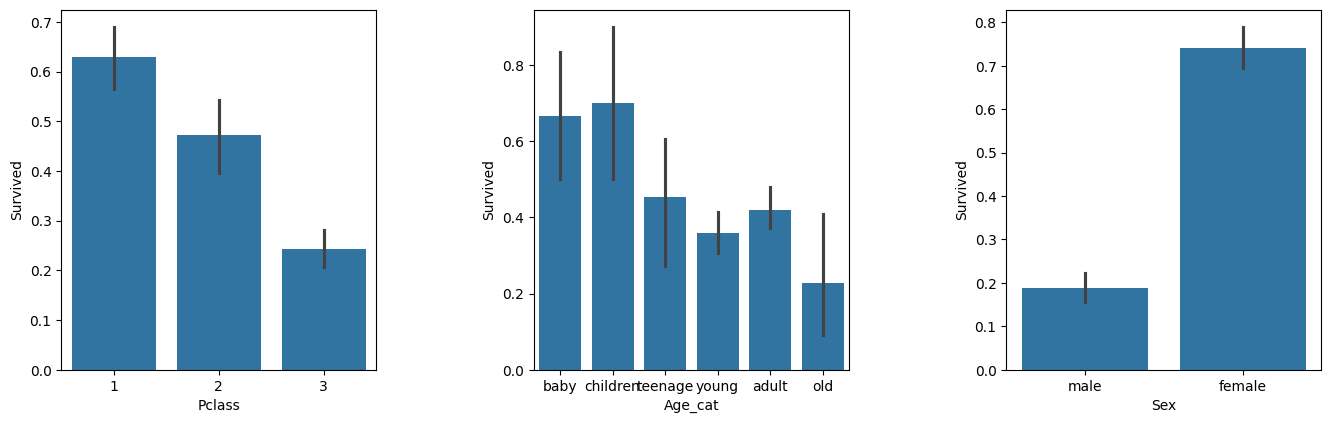

In [13]:
# 등급, 나이대, 성별에 따른 생존률 시각화
plt.figure(figsize=[14,4])
plt.subplot(131)
sns.barplot(x='Pclass', y='Survived', data=raw_data)
plt.subplot(132)
sns.barplot(x='Age_cat', y='Survived', data=raw_data)
plt.subplot(133)
sns.barplot(x='Sex', y='Survived', data=raw_data)
plt.subplots_adjust(top=1, bottom=0.1, left=0.10, right=1, hspace=0.5, wspace=0.5)
plt.show()

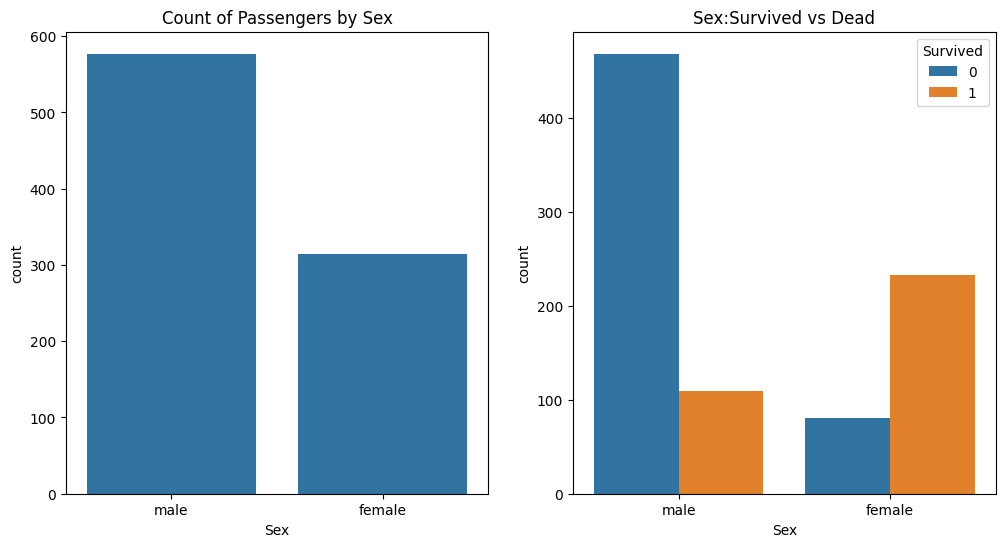

In [14]:
# 성별에 따른 생존 여부 시각화
f,ax=plt.subplots(1,2,figsize=(12,6))
sns.countplot(x='Sex', data=raw_data, ax=ax[0])
ax[0].set_title('Count of Passengers by Sex')

sns.countplot(x='Sex', hue='Survived', data=raw_data, ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

## 7-5. 귀족들의 생존률만 다시 조사해보기

In [15]:
raw_data['Name'][0]

'Braund, Mr. Owen Harris'

In [16]:
raw_data['Name'][0].split(',')[1]

' Mr. Owen Harris'

In [17]:
raw_data['Name'][0].split(',')[1].split('.')[0]

' Mr'

In [18]:
raw_data['Name'][0].split(',')[1].split('.')[0].strip()

'Mr'

In [19]:
test = lambda x: x+2
test(2)

4

In [20]:
list(map(test, range(5)))

[2, 3, 4, 5, 6]

In [21]:
conversion_rare = lambda x: x.split(',')[1].split('.')[0].strip()
raw_data['Title'] = raw_data['Name'].map(conversion_rare)

titles = raw_data['Title'].unique()
titles

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [22]:
pd.crosstab(raw_data['Title'], raw_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40
Miss,182,0


In [23]:
raw_data['Title'] = raw_data['Title'].replace('Mlle', 'Miss')
raw_data['Title'] = raw_data['Title'].replace('Ms', 'Miss')
raw_data['Title'] = raw_data['Title'].replace('Mme', 'Mrs')

Rare = ['Lady','the Countess','Countess','Capt', 'Master',
        'Col','Don','Dr','Major','Rev','Sir','Jonkheer', 'Dona']

for each in Rare:
    raw_data['Title'] = raw_data['Title'].replace(each, 'Rare')
    
raw_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Rare'], dtype=object)

In [24]:
print (raw_data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

  Title  Survived
0  Miss  0.702703
1    Mr  0.156673
2   Mrs  0.793651
3  Rare  0.492063


## 7-6. 학습하기 위해 데이터를 정리하고, 특징을 선택하기

In [25]:
raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,young,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,young,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult,Mr


In [26]:
tmp = []
for each in raw_data['Sex']:
    if each == 'female':
        tmp.append(0)
    elif each == 'male':
        tmp.append(1)
    else:
        tmp.append(np.nan)

In [27]:
raw_data['Sex'] = tmp
raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,young,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,adult,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,young,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,adult,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,adult,Mr


In [28]:
raw_data['Survived'] = raw_data['Survived'].astype('float')
raw_data['Pclass'] = raw_data['Pclass'].astype('float')
raw_data['Sex'] = raw_data['Sex'].astype('float')
raw_data['Sibsp'] = raw_data['SibSp'].astype('float')
raw_data['Parch'] = raw_data['Parch'].astype('float')
raw_data['Fare'] = raw_data['Fare'].astype('float')
raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat,Title,Sibsp
0,1,0.0,3.0,"Braund, Mr. Owen Harris",1.0,22.0,1,0.0,A/5 21171,7.2500,NaN,S,young,Mr,1.0
1,2,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,38.0,1,0.0,PC 17599,71.2833,C85,C,adult,Mrs,1.0
2,3,1.0,3.0,"Heikkinen, Miss. Laina",0.0,26.0,0,0.0,STON/O2. 3101282,7.9250,NaN,S,young,Miss,0.0
3,4,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,35.0,1,0.0,113803,53.1000,C123,S,adult,Mrs,1.0
4,5,0.0,3.0,"Allen, Mr. William Henry",1.0,35.0,0,0.0,373450,8.0500,NaN,S,adult,Mr,0.0


In [29]:
raw_data = raw_data[raw_data['Age'].notnull()]
raw_data = raw_data[raw_data['SibSp'].notnull()]
raw_data = raw_data[raw_data['Parch'].notnull()]
raw_data = raw_data[raw_data['Fare'].notnull()]
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  714 non-null    int64   
 1   Survived     714 non-null    float64 
 2   Pclass       714 non-null    float64 
 3   Name         714 non-null    object  
 4   Sex          714 non-null    float64 
 5   Age          714 non-null    float64 
 6   SibSp        714 non-null    int64   
 7   Parch        714 non-null    float64 
 8   Ticket       714 non-null    object  
 9   Fare         714 non-null    float64 
 10  Cabin        185 non-null    object  
 11  Embarked     712 non-null    object  
 12  Age_cat      714 non-null    category
 13  Title        714 non-null    object  
 14  Sibsp        714 non-null    float64 
dtypes: category(1), float64(7), int64(2), object(5)
memory usage: 84.6+ KB


## 7-7 생존자 예측을 위한 모델 수립

In [30]:
train_pre = raw_data[['Pclass','Sex','Age','SibSp','Parch','Fare']]
train_pre.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3.0,1.0,22.0,1,0.0,7.2500
1,1.0,0.0,38.0,1,0.0,71.2833
2,3.0,0.0,26.0,0,0.0,7.9250
3,1.0,0.0,35.0,1,0.0,53.1000
4,3.0,1.0,35.0,0,0.0,8.0500


In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_pre, 
                                                    raw_data[['Survived']], 
                                                    test_size=0.1, 
                                                    random_state=13)

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 642 entries, 328 to 422
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  642 non-null    float64
 1   Sex     642 non-null    float64
 2   Age     642 non-null    float64
 3   SibSp   642 non-null    int64  
 4   Parch   642 non-null    float64
 5   Fare    642 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 35.1 KB


In [33]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 769 to 401
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  72 non-null     float64
 1   Sex     72 non-null     float64
 2   Age     72 non-null     float64
 3   SibSp   72 non-null     int64  
 4   Parch   72 non-null     float64
 5   Fare    72 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 3.9 KB


In [34]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 642 entries, 328 to 422
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  642 non-null    float64
dtypes: float64(1)
memory usage: 10.0 KB


In [35]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 769 to 401
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  72 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


In [36]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
328,3.0,0.0,31.0,1,1.0,20.5250
665,2.0,1.0,32.0,2,0.0,73.5000
281,3.0,1.0,28.0,0,0.0,7.8542
427,2.0,0.0,19.0,0,0.0,26.0000
129,3.0,1.0,45.0,0,0.0,6.9750


In [37]:
X_train = X_train.reset_index()
X_train = X_train.drop(['index'], axis=1)

X_test = X_test.reset_index()
X_test = X_test.drop(['index'], axis=1)

y_train = y_train.reset_index()
y_train = y_train.drop(['index'], axis=1)

y_test = y_test.reset_index()
y_test = y_test.drop(['index'], axis=1)

In [38]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=13)
tree_clf.fit(X_train, y_train)

print('Score: {}'.format(tree_clf.score(X_train, y_train)))

Score: 0.8193146417445483


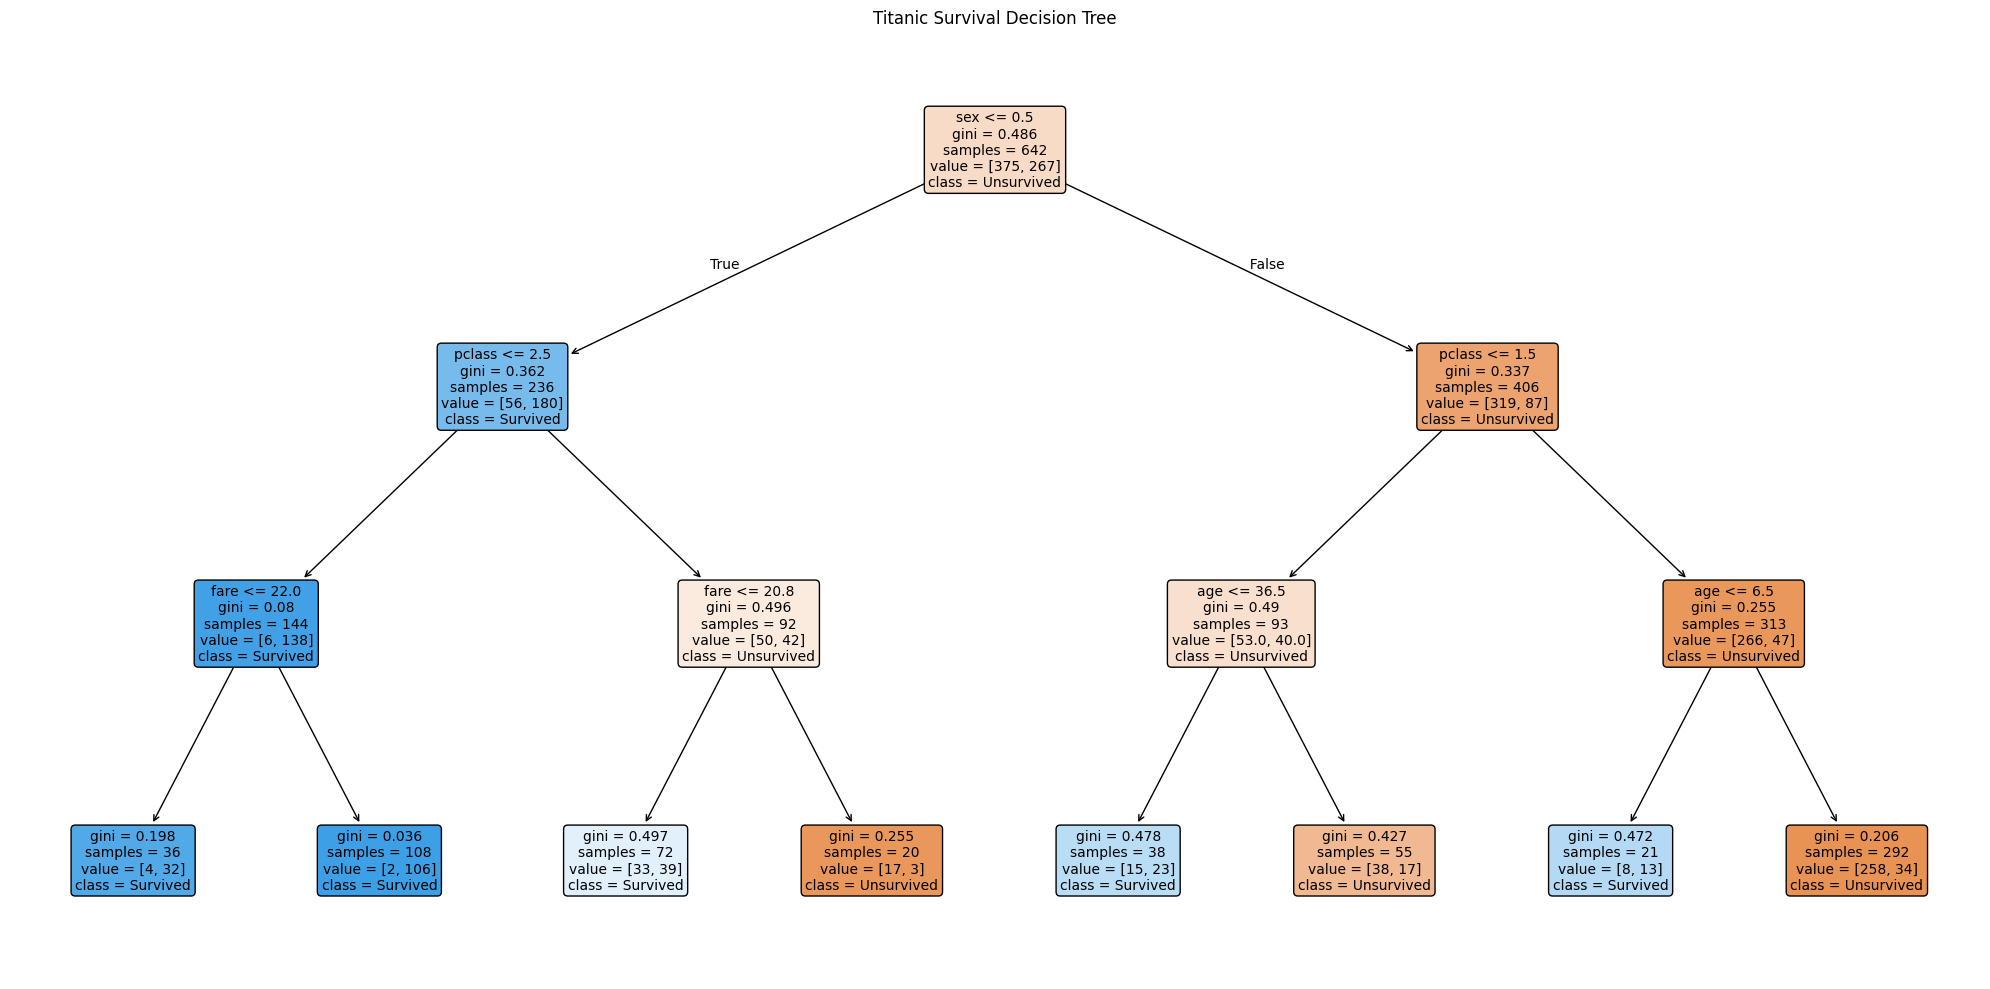

In [39]:
# Graphviz 없이 Decision Tree 시각화 (plot_tree 사용)
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(tree_clf,
          feature_names=['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare'],
          class_names=['Unsurvived', 'Survived'],
          rounded=True,
          filled=True,
          fontsize=10)
plt.title('Titanic Survival Decision Tree')
plt.tight_layout()
plt.show()

In [40]:
from sklearn.metrics import accuracy_score

y_pred = tree_clf.predict(X_test)
print("Test Accuracy is ", accuracy_score(y_test, y_pred)*100)

Test Accuracy is  81.94444444444444


## 7-8. 생존자 예측해보기. 디카프리오는 정말 생존할 수 없었을까

In [41]:
!pip list

Package                   Version
------------------------- -----------
alembic                   1.18.0
asttokens                 3.0.1
attrs                     25.4.0
colorama                  0.4.6
colorlog                  6.10.1
comm                      0.2.3
contourpy                 1.3.3
cycler                    0.12.1
debugpy                   1.8.19
decorator                 5.2.1
executing                 2.2.1
fastjsonschema            2.21.2
fonttools                 4.61.1
graphviz                  0.21
greenlet                  3.3.0
ipykernel                 7.1.0
ipython                   9.9.0
ipython_pygments_lexers   1.1.1
jedi                      0.19.2
joblib                    1.5.3
jsonschema                4.26.0
jsonschema-specifications 2025.9.1
jupyter_client            8.8.0
jupyter_core              5.9.1
kiwisolver                1.4.9
lightgbm                  4.6.0
Mako                      1.3.10
MarkupSafe                3.0.3
matplotlib          

In [42]:
# pclass, sex, age, sibsp, parch, fare
dicaprio = [3., 1., 19., 0., 0., 5.]
winslet = [1., 0., 17., 1., 1., 100.]

In [43]:
tree_clf.predict_proba([winslet])

c:\Users\park0\miniconda3\envs\myDS\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([[0.01851852, 0.98148148]])

In [44]:
tree_clf.predict_proba([dicaprio])

c:\Users\park0\miniconda3\envs\myDS\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([[0.88356164, 0.11643836]])

In [45]:
def isSurvived(name, person):
    isSurvive = 'not survived' if tree_clf.predict([person])[0] == 0 else 'survived'
    print(name, ' is ', isSurvive, 
          ' --> ', max(tree_clf.predict_proba([person])[0]))
    
isSurvived('Dicaprio', dicaprio)
isSurvived('Winslet', winslet)

Dicaprio  is  not survived  -->  0.8835616438356164
Winslet  is  survived  -->  0.9814814814814815


c:\Users\park0\miniconda3\envs\myDS\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\park0\miniconda3\envs\myDS\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\park0\miniconda3\envs\myDS\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\park0\miniconda3\envs\myDS\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
